**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0920, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from scipy.spatial import distance
from sklearn.neighbors import KDTree

#####**Мой класс и функции**


In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean', standartisation=False):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        self.standartisation = standartisation

    def make_distance_matrix(self, X):
        return pairwise_distances(X, self.X_train, self.metric)

    def make_standartisation(self, X):
        return (X - X.mean()) / X.std()

    def brute(self, X):
        distance_matrix = self.make_distance_matrix(X)
        indices = np.argpartition(distance_matrix, self.n_neighbors)[:,:self.n_neighbors]
        k_smallest_indices = np.take_along_axis(indices, np.argsort(np.take_along_axis(distance_matrix, indices, axis=1), axis=1), axis=1)[:, ::-1]
        return k_smallest_indices
    
    def fit(self, X, y):
        self.X_train = X.copy()
        self.y_train = y.copy()
        if self.standartisation:
            self.X_train = self.make_standartisation(self.X_train)

        if self.algorithm == 'kd_tree':
            if self.metric not in KDTree.valid_metrics:
                self.metric = 'euclidean'
            self.kd_tree = KDTree(self.X_train, metric=self.metric)           
    
    def predict(self, X):
        if self.standartisation:
            X = self.make_standartisation(X)
        if self.algorithm == 'brute':
            indices = self.brute(X)
        elif self.algorithm == 'kd_tree':
            _, indices = self.kd_tree.query(X, k=self.n_neighbors)

        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=self.y_train[indices])

In [3]:
def get_score(X, y, k, algorithm='brute', metric='cosine', n_splits=3, standartisation=True, print_all=True):
    """
    Кросс-валидация
    """
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    count = 1
    if print_all:
        print(f'k = {k}, algorithm = {algorithm}, metric = {metric}, standartisation = {standartisation}, shape = {X.shape}')
    for train_index, test_index in cv.split(X):
        try:
            X_train, X_test = X[train_index].toarray(), X[test_index].toarray()
        except AttributeError:
            X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        my_clf = MyKNeighborsClassifier(n_neighbors=k, algorithm=algorithm, metric=metric, standartisation=standartisation)
        my_clf.fit(X_train, y_train)
        my_clf_pred = my_clf.predict(X_test)
        score = accuracy_score(y_test, my_clf_pred)
        scores.append(score)
        if print_all:
            print(f'{count}/{n_splits}: {score}')
        count += 1
    scores = np.asarray(scores)
    if print_all:
        print(f'MEAN: {scores.mean()}')
        print()
        print()
    return scores.mean()

In [4]:
def plot_acc(array_of_k, array_of_acc, title=None):
    """
    Построение графиков k/accuracy
    """
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(15)

    ax = fig.add_subplot()

    ax.plot(array_of_k, array_of_acc)

    ax.set_xlabel('k')
    ax.set_ylabel('Accuracy')

    if title:
        ax.set_title(title)

    plt.show()

In [5]:
def plot_acc_1(array_of_k, score_data, title=None):
    """
    Построение нескольких графиков k/accuracy, вложенность 1
    """
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(15)

    ax = fig.add_subplot()
    ax.set_xlabel('k')
    ax.set_ylabel('Accuracy')

    for p1 in score_data:
        array_of_acc = score_data[p1]

        param = str((p1))
        ax.plot(array_of_k, array_of_acc, label=param)

    if title:
        ax.set_title(title)
    ax.legend()

    plt.show()

In [6]:
def literal_ind(vectorizer):
    """
    Удаление из словаря слов, состоящих не из символов a-z
    """
    ind_to_del = []
    ind = []
    for i, word in enumerate(vectorizer.get_feature_names()):
        for c in word.lower():
            if c < 'a' or c > 'z':
                ind_to_del.append(i)
                break
        if i != ind_to_del[-1]:
            ind.append(i)
    return ind

In [7]:
def get_score_vectorizer(array_k, sublinear_tf=True, max_df=0.1, min_df=0.01, max_features=2000, literal=False, standartisation=True, make_plot=True, print_all=True, print_best=True):
    vectorizer = TfidfVectorizer(sublinear_tf=sublinear_tf, max_df=max_df, min_df=min_df, max_features=max_features)

    X_data = vectorizer.fit_transform(data)

    if literal:
        ind_literal = literal_ind(vectorizer)
        X_data = X_data[:, ind_literal]

    scores = []

    best = 0
    best_score = 0

    for k in array_k:
        score = get_score(X_data, target, k, standartisation=standartisation, print_all=print_all)
        if score > best_score:
            best_score = score
            best = k
        scores.append(score)
    
    if print_all or print_best:
        print(f'Best score is {best_score}\nk = {best}')
        print()
        print()
    if make_plot:
        plot_acc(array_k, scores, f'{X_data.shape[1]} features')
    
    return scores

##### **Задание 1 (1 балл)**
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [32]:
iris = datasets.load_iris()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [34]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [35]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [36]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
sklearn_score = accuracy_score(y_test, sklearn_pred)
my_score = accuracy_score(y_test, my_clf_pred)
assert abs( accuracy_score(y_test, my_clf_pred) - accuracy_score(y_test, sklearn_pred) ) < 0.005, f"Score must be simillar, {my_score} != {sklearn_score}"

#####**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [37]:
%time clf.fit(X_train, y_train)

CPU times: user 1.4 ms, sys: 0 ns, total: 1.4 ms
Wall time: 1.2 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [38]:
%time my_clf.fit(X_train, y_train)

CPU times: user 64 µs, sys: 14 µs, total: 78 µs
Wall time: 55.1 µs


In [39]:
%time clf.predict(X_test)

CPU times: user 2.35 ms, sys: 69 µs, total: 2.42 ms
Wall time: 2.2 ms


array([2, 0, 1, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0, 1])

In [40]:
%time my_clf.predict(X_test)

CPU times: user 951 µs, sys: 1 ms, total: 1.95 ms
Wall time: 1.95 ms


array([2, 0, 1, 2, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0, 1])

##### **Задание 3 (1 балл)**
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [41]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree', metric='cosine')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [43]:
%time clf.fit(X_train, y_train)

CPU times: user 1.55 ms, sys: 0 ns, total: 1.55 ms
Wall time: 2.45 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [44]:
%time my_clf.fit(X_train, y_train)

CPU times: user 202 µs, sys: 44 µs, total: 246 µs
Wall time: 252 µs


In [45]:
%time clf.predict(X_test)

CPU times: user 4.2 ms, sys: 0 ns, total: 4.2 ms
Wall time: 7.57 ms


array([2, 1, 1, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 2, 1])

In [46]:
%time my_clf.predict(X_test)

CPU times: user 1.11 ms, sys: 20 µs, total: 1.13 ms
Wall time: 869 µs


array([2, 1, 1, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 2, 1])

In [47]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred) ) < 0.005, "Score must be simillar"

#####**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [ ]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [ ]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [ ]:
max_features = 1000
vectorizer = CountVectorizer(max_features=max_features)
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

X_data = vectorizer.fit_transform(data)
X_data_tfidf = tfidf_vectorizer.fit_transform(data)

X_data.shape, X_data_tfidf.shape

((11314, 1000), (11314, 1000))

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [ ]:
# Реализовано в функции get_score

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [45]:
%%time
array_k = np.arange(1, 11)
array_algorithm = ['brute', 'kd_tree']
array_metric = ['euclidean', 'cosine']

scores = []
scores_param = []

best = (0, '', '')
best_score = 0

for k in array_k:
    for algorithm in array_algorithm:
        for metric in array_metric:
            if metric == 'cosine' and algorithm == 'kd_tree':
                continue

            print('CountVectorizer:')
            param = (k, algorithm, metric, 'CountVectorizer')
            score = get_score(X_data, target, k, algorithm, metric)
            if score > best_score:
                best_score = score
                best = param
            scores.append(score)
            scores_param.append(param)

            print('TfidfVectorizer:')
            param = (k, algorithm, metric, 'TfidfVectorizer')
            score = get_score(X_data_tfidf, target, k, algorithm, metric)
            if score > best_score:
                best_score = score
                best = param
            scores.append(score)
            scores_param.append(param)
            print()

print(f'Best score is {best_score}\nk = {best[0]}, algorithm = {best[1]}, metric = {best[2]}, vectorizer = {best[3]}')

In [ ]:
score_data = {}
for i in range (len(scores)):
    k, algorithm, metric, vectorizer = scores_param[i]
    if vectorizer not in score_data:
        score_data[vectorizer] = {}
    if algorithm not in score_data[vectorizer]:
        score_data[vectorizer][algorithm] = {}
    if metric not in score_data[vectorizer][algorithm]:
        score_data[vectorizer][algorithm][metric] = []
    score_data[vectorizer][algorithm][metric].append(scores[i])

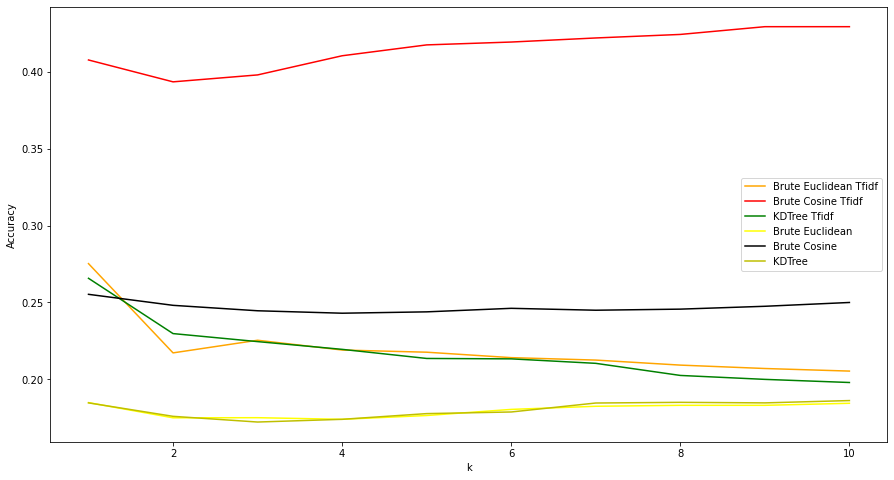

In [ ]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(15)

ax = fig.add_subplot()

ax.plot(array_k, score_data['TfidfVectorizer']['brute']['euclidean'], color='orange', label='Brute Euclidean Tfidf')
ax.plot(array_k, score_data['TfidfVectorizer']['brute']['cosine'], color='red', label='Brute Cosine Tfidf')
ax.plot(array_k, score_data['TfidfVectorizer']['kd_tree']['euclidean'], color='green', label='KDTree Tfidf')
ax.plot(array_k, score_data['CountVectorizer']['brute']['euclidean'], color='yellow', label='Brute Euclidean')
ax.plot(array_k, score_data['CountVectorizer']['brute']['cosine'], color='black', label='Brute Cosine')
ax.plot(array_k, score_data['CountVectorizer']['kd_tree']['euclidean'], color='y', label='KDTree')

ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
ax.legend()

plt.show()

###### Поиск параметров

In [152]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])
data = newsgroups['data']
target = newsgroups['target']

Найдем оптимальные значения k

k = 5, algorithm = brute, metric = cosine
1/3: 0.4517497348886532
2/3: 0.4478918058870326
3/3: 0.4478918058870326
MEAN: 0.44917778222090615



k = 10, algorithm = brute, metric = cosine
1/3: 0.49045599151643693
2/3: 0.4847520551577831
3/3: 0.48899496154866084
MEAN: 0.48806766940762697



k = 15, algorithm = brute, metric = cosine
1/3: 0.5053022269353128
2/3: 0.5104746751524795
3/3: 0.4972155926809865
MEAN: 0.5043308315895929



k = 20, algorithm = brute, metric = cosine
1/3: 0.5198833510074231
2/3: 0.514982763192787
3/3: 0.5099443118536198
MEAN: 0.51493680868461



k = 25, algorithm = brute, metric = cosine
1/3: 0.524390243902439
2/3: 0.5202863961813843
3/3: 0.5125961283479183
MEAN: 0.5190909228105806



k = 30, algorithm = brute, metric = cosine
1/3: 0.5259809119830329
2/3: 0.5176345796870857
3/3: 0.5205515778308141
MEAN: 0.5213890231669775



k = 35, algorithm = brute, metric = cosine
1/3: 0.5349946977730647
2/3: 0.5202863961813843
3/3: 0.5242641209228321
MEAN: 0.5265150716257604





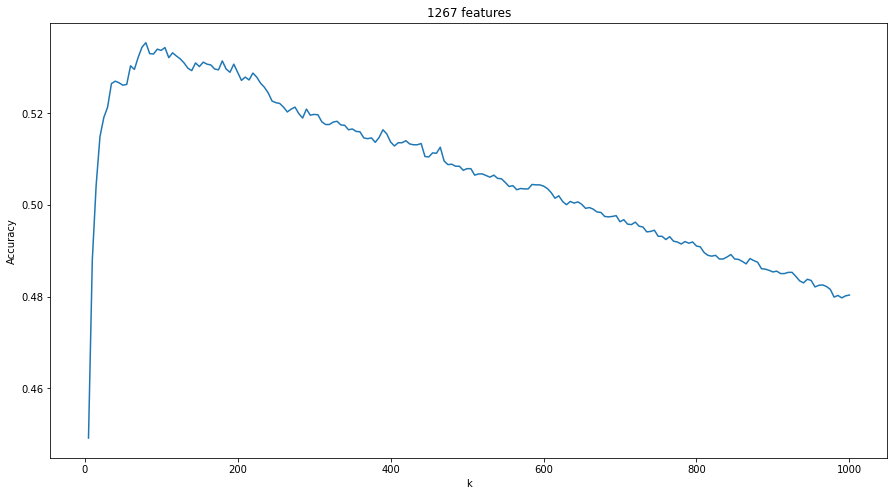

CPU times: user 49min 48s, sys: 1min 15s, total: 51min 4s
Wall time: 29min 16s


In [105]:
# без стандартизации
%%time
array_k = np.arange(5, 1001, 5)
scores = get_score_vectorizer(array_k)

k = 5, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 1216)
1/3: 0.44538706256627786
2/3: 0.43967117475470696
3/3: 0.43595863166268894
MEAN: 0.4403389563278912


k = 15, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 1216)
1/3: 0.5039766702014846
2/3: 0.4958896844338372
3/3: 0.500132590824715
MEAN: 0.4999996484866789


k = 25, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 1216)
1/3: 0.5270413573700954
2/3: 0.5088835852559003
3/3: 0.5136568549456377
MEAN: 0.5165272658572111


k = 35, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 1216)
1/3: 0.5373806998939554
2/3: 0.5173693980376558
3/3: 0.5213471227791037
MEAN: 0.525365740236905


k = 45, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 1216)
1/3: 0.5416224814422057
2/3: 0.5192256695836648
3/3: 0.520816759480244
MEAN: 0.5272216368353715


k = 55, algorithm = brute, metric = cosine, standartisat

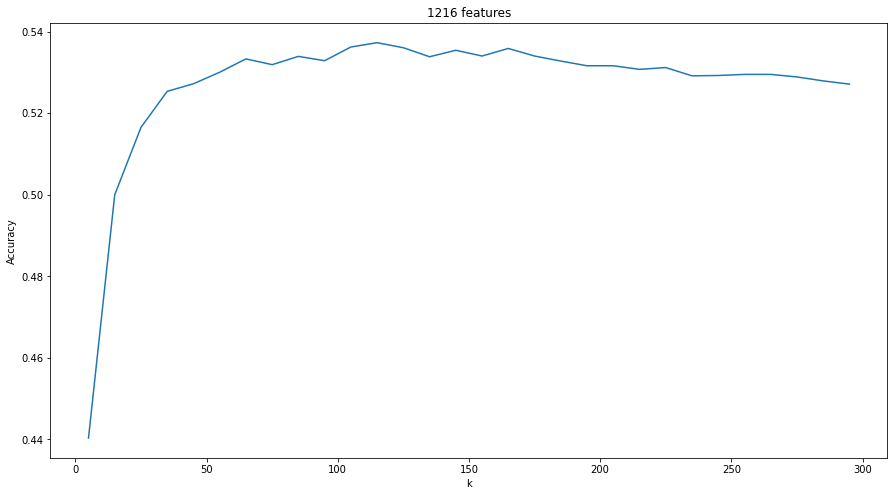

CPU times: user 7min 14s, sys: 10.8 s, total: 7min 25s
Wall time: 4min 18s


In [213]:
%%time
array_k = np.arange(5, 300, 10)
scores = get_score_vectorizer(array_k, literal=True)

*sublinear_tf*

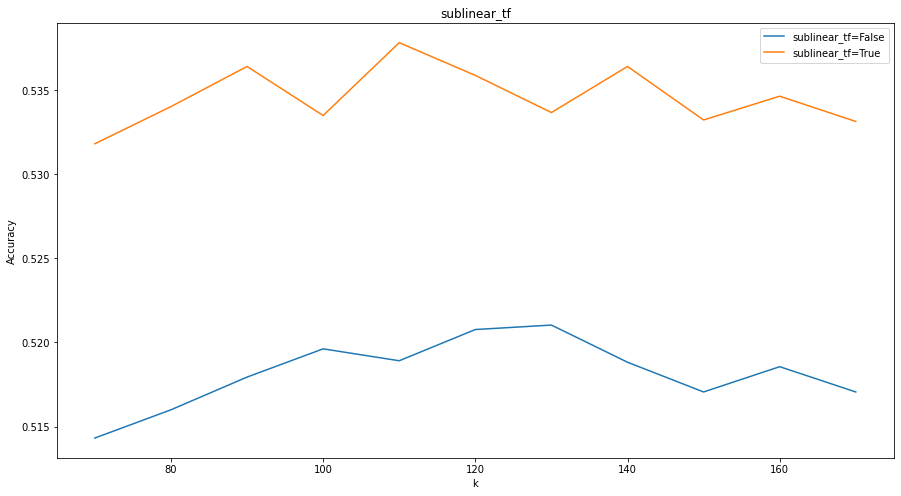

CPU times: user 5min 24s, sys: 7.71 s, total: 5min 31s
Wall time: 3min 11s


In [215]:
%%time
array_k = np.arange(70, 171, 10)

score_data = {}
score_data['sublinear_tf=False'] = get_score_vectorizer(array_k, sublinear_tf=False, print_all=False, make_plot=False, print_best=False)
score_data['sublinear_tf=True'] = get_score_vectorizer(array_k, sublinear_tf=True, print_all=False, make_plot=False, print_best=False)

plot_acc_1(array_k, score_data, 'sublinear_tf')

*Поэтому везде выставим sublinear_tf=True*

k = 75, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6874337221633086
2/3: 0.6785998408910103
3/3: 0.6820472023335985
MEAN: 0.6826935884626392


k = 80, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6887592788971368
2/3: 0.6785998408910103
3/3: 0.6820472023335985
MEAN: 0.6831354407072485


k = 85, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6861081654294804
2/3: 0.6730310262529833
3/3: 0.677539114293291
MEAN: 0.6788927686585847


k = 90, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6874337221633086
2/3: 0.6730310262529833
3/3: 0.6732962079024132
MEAN: 0.6779203187729017


k = 95, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6861081654294804
2/3: 0.6743569345001326
3/3: 0.6703792097586847
MEAN: 0.6769481032294326


k = 100, algorithm = brute, metric = cosine, standartisa

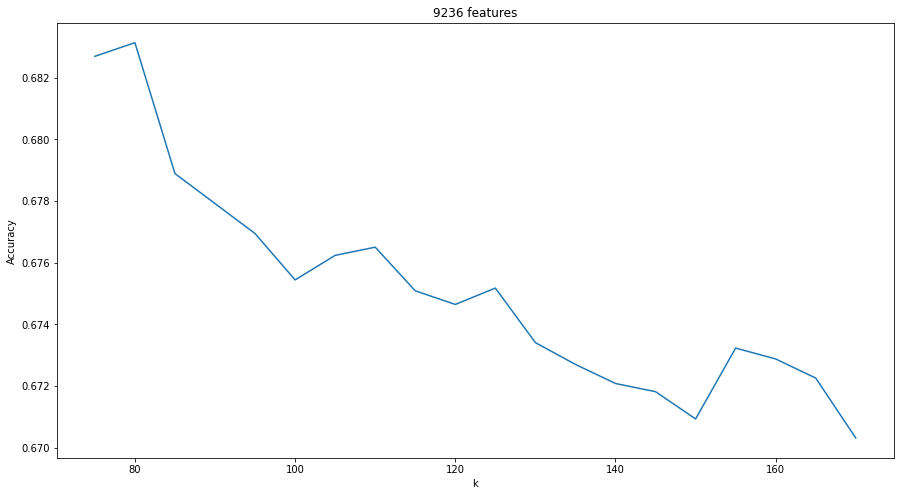

CPU times: user 32min 48s, sys: 12.6 s, total: 33min 1s
Wall time: 17min 52s


In [220]:
%%time
array_k = np.arange(75, 171, 5)
get_score_vectorizer(array_k, min_df=0.001, max_features=100000)

*Видимо, для такого количества признаков оптимальное k меньше*

k = 5, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6306998939554613
2/3: 0.6337841421373641
3/3: 0.6327234155396446
MEAN: 0.6324024838774901


k = 10, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6542948038176034
2/3: 0.6608326703792098
3/3: 0.6645452134712277
MEAN: 0.659890895889347


k = 15, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6805408271474019
2/3: 0.6711747547069743
3/3: 0.6730310262529833
MEAN: 0.6749155360357865


k = 20, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6810710498409331
2/3: 0.67913020418987
3/3: 0.6756828427472819
MEAN: 0.6786280322593616


k = 25, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6845174973488866
2/3: 0.6815168390347388
3/3: 0.6754176610978521
MEAN: 0.6804839991604924


k = 30, algorithm = brute, metric = cosine, standartisation

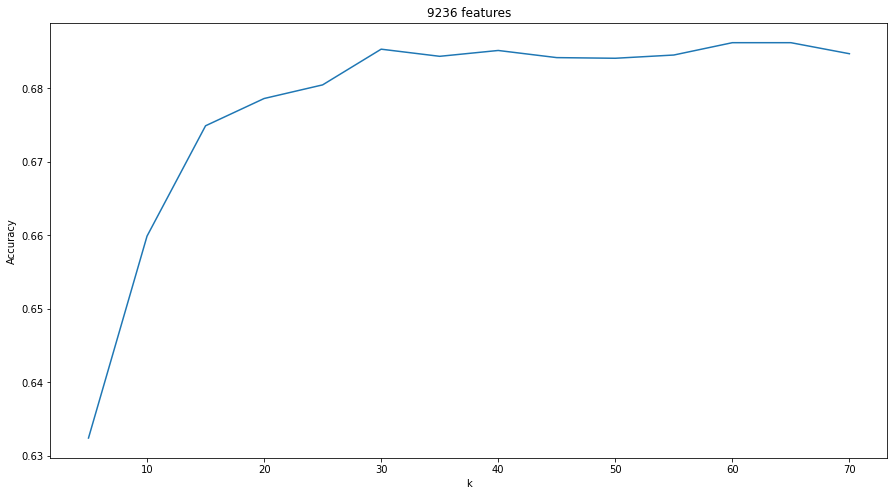

CPU times: user 22min 48s, sys: 8.77 s, total: 22min 57s
Wall time: 12min 23s


In [221]:
%%time
array_k = np.arange(5, 75, 5)
get_score_vectorizer(array_k, min_df=0.001, max_features=100000)

k = 28, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6850477200424178
2/3: 0.6852293821267569
3/3: 0.6764783876955714
MEAN: 0.6822518299549154


k = 29, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6879639448568399
2/3: 0.6870856536727659
3/3: 0.67913020418987
MEAN: 0.684726600906492


k = 30, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6871686108165429
2/3: 0.6873508353221957
3/3: 0.6815168390347388
MEAN: 0.6853454283911592


k = 31, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6866383881230117
2/3: 0.6902678334659241
3/3: 0.6756828427472819
MEAN: 0.6841963547787392


k = 32, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 9236)
1/3: 0.6876988335100742
2/3: 0.6876160169716256
3/3: 0.6764783876955714
MEAN: 0.6839310793924237


k = 38, algorithm = brute, metric = cosine, standartisatio

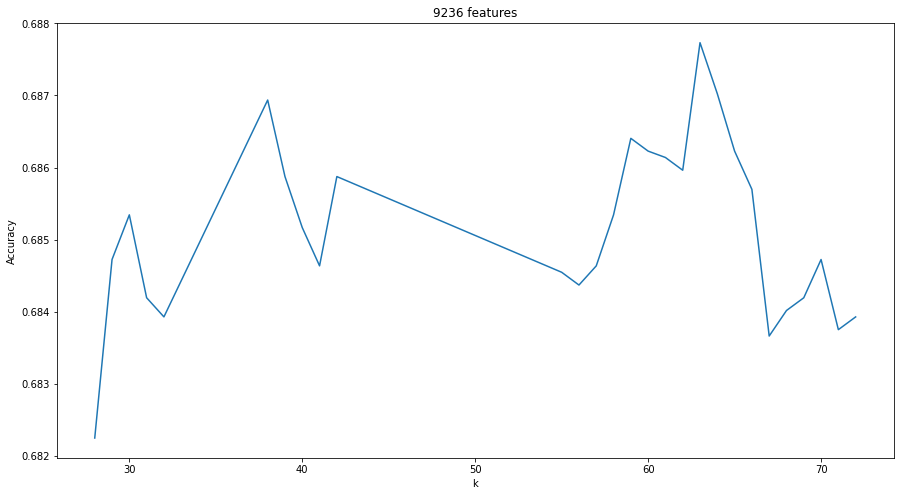

CPU times: user 45min 30s, sys: 17.9 s, total: 45min 48s
Wall time: 24min 45s


In [222]:
%%time
array_k = [28, 29, 30, 31, 32, 38, 39, 40, 41, 42, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
scores = get_score_vectorizer(array_k, min_df=0.001, max_features=100000)

*Попробуем улучшить результат, оставив в словаре только обычные английские слова (из символов a-z)*

k = 30, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6850477200424178
2/3: 0.6804561124370193
3/3: 0.6788650225404402
MEAN: 0.6814562850066258


k = 38, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6914103923647932
2/3: 0.6870856536727659
3/3: 0.6825775656324582
MEAN: 0.6870245372233391


k = 39, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6895546129374337
2/3: 0.6878811986210555
3/3: 0.6836382922301777
MEAN: 0.6870247012628888


k = 40, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.690880169671262
2/3: 0.686820472023336
3/3: 0.6820472023335985
MEAN: 0.6865826146760655


k = 41, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.690084835630965
2/3: 0.6865552903739062
3/3: 0.6823123839830284
MEAN: 0.6863175033292999


k = 42, algorithm = brute, metric = cosine, standartisatio

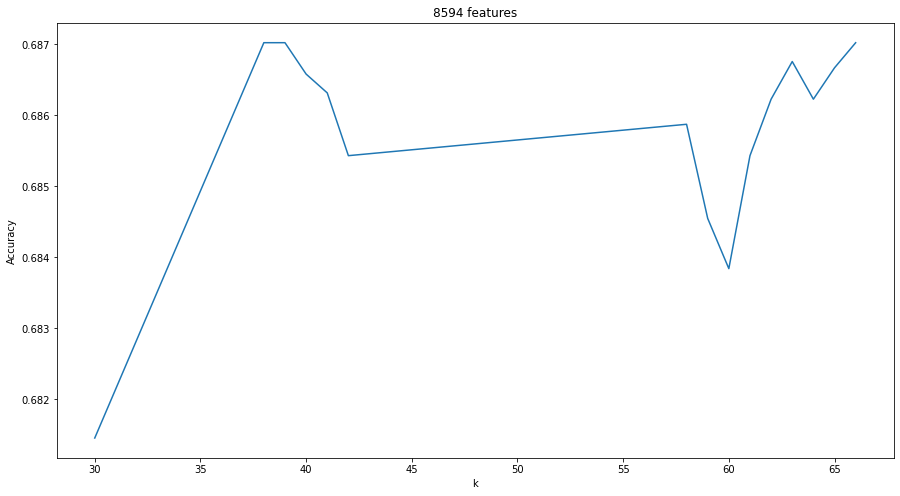

CPU times: user 22min 49s, sys: 9.56 s, total: 22min 59s
Wall time: 12min 26s


In [224]:
%%time
array_k = [30, 38, 39, 40, 41, 42, 58, 59, 60, 61, 62, 63, 64, 65, 66]
scores = get_score_vectorizer(array_k, min_df=0.001, max_features=100000, literal=True)

k = 31, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6876988335100742
2/3: 0.6854945637761867
3/3: 0.6807212940864492
MEAN: 0.68463823045757


k = 32, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6887592788971368
2/3: 0.6846990188278971
3/3: 0.6815168390347388
MEAN: 0.6849917122532575


k = 33, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6924708377518558
2/3: 0.6839034738796075
3/3: 0.6799257491381596
MEAN: 0.6854333535898743


k = 34, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6924708377518558
2/3: 0.6841686555290374
3/3: 0.6807212940864492
MEAN: 0.6857869291224475


k = 35, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6916755037115588
2/3: 0.6846990188278971
3/3: 0.6793953858392999
MEAN: 0.685256636126252


k = 36, algorithm = brute, metric = cosine, standartisatio

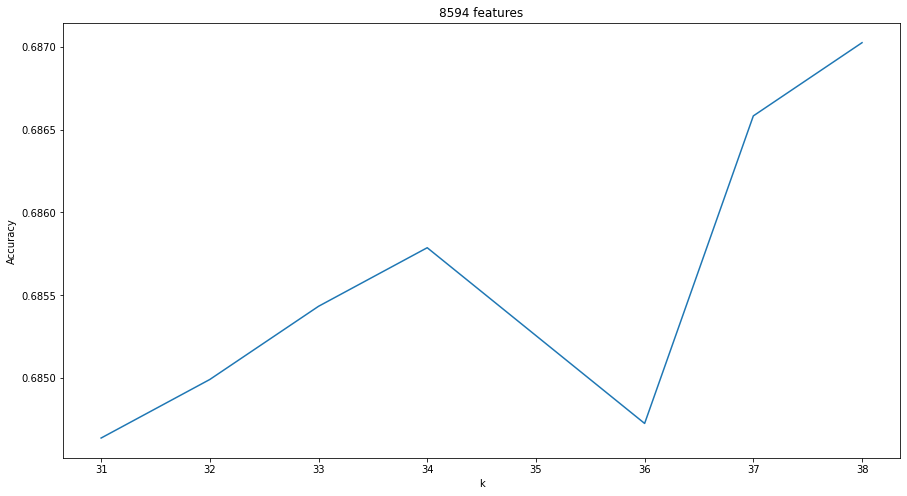

CPU times: user 12min 11s, sys: 4.82 s, total: 12min 16s
Wall time: 6min 39s


In [227]:
%%time
array_k = np.arange(31, 39)
scores = get_score_vectorizer(array_k, min_df=0.001, max_features=100000, literal=True)

k = 66, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6951219512195121
2/3: 0.6809864757358791
3/3: 0.684964200477327
MEAN: 0.6870242091442395


k = 67, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6924708377518558
2/3: 0.6804561124370193
3/3: 0.6836382922301777
MEAN: 0.6855217474730176


k = 68, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6895546129374337
2/3: 0.6788650225404402
3/3: 0.6839034738796075
MEAN: 0.6841077031191606


k = 69, algorithm = brute, metric = cosine, standartisation = True, shape = (11314, 8594)
1/3: 0.6911452810180275
2/3: 0.6764783876955714
3/3: 0.6823123839830284
MEAN: 0.6833120175655424


Best score is 0.6870242091442395
k = 66




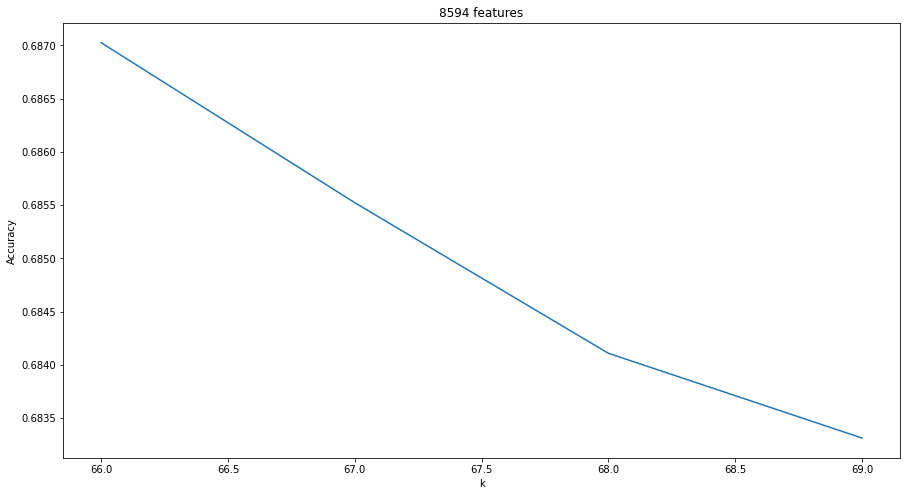

CPU times: user 6min 7s, sys: 3.03 s, total: 6min 10s
Wall time: 3min 21s


In [226]:
%%time
array_k = np.arange(66, 70)
scores = get_score_vectorizer(array_k, min_df=0.001, max_features=100000, literal=True)

*Результат стал немного хуже, видимо моя идея не работает*

*Я пробовал делать трейн на 40000 фичах (из ноутбука это случайно удалилось) и прирост был небольшим относительно затраченного времени, так что я принял решение остановиться на числе до 10000 фичей*

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

*Лучшей моделью была модель с количеством соседей 63*

In [8]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])
data = newsgroups['data']
target = newsgroups['target']

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.1, min_df=0.001, max_features=10000)

X_data = vectorizer.fit_transform(data)
X_data.shape

#ind_literal = literal_ind(vectorizer)
#X_data = X_data[:, ind_literal]

(11314, 9236)

In [9]:
best = 63

In [15]:
model = MyKNeighborsClassifier(n_neighbors=best, algorithm='brute', metric='cosine', standartisation=True)
model.fit(X_data.toarray(), target)
best

63

In [16]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [17]:
data_test = newsgroups_test['data']
target_test = newsgroups_test['target']
target_test = target_test.reshape(-1, 1)
target_test.shape

(7532, 1)

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [18]:
X_test_data = vectorizer.transform(data_test)

X_test_data.toarray().shape

#X_test_data = X_test_data[:, ind_literal]
#X_test_data.shape

(7532, 9236)

In [19]:
%%time
test_pred = model.predict(X_test_data.toarray())
score = accuracy_score(target_test, test_pred)
print(score) 

0.6501593202336696
CPU times: user 1min 33s, sys: 662 ms, total: 1min 34s
Wall time: 49.4 s


**Итоговый score = 0.6501593202336696**

Качество может отличаться из-за отсутствия одних слов и присутствия других в тестовом датасете

Ниже примеры старых тестов, сохранил для истории

In [ ]:
### max_df=0.1, min_df=0.01, 8594, k=40, literal
#%%time
#test_pred = model.predict(X_test_data.toarray())
#score = accuracy_score(target_test, test_pred)
#print(score) 

###0.6384758364312267
###CPU times: user 16min 38s, sys: 877 ms, total: 16min 39s
###Wall time: 16min 40s

0.6384758364312267
CPU times: user 16min 38s, sys: 877 ms, total: 16min 39s
Wall time: 16min 40s


In [ ]:
### max_df=0.1, min_df=0.001, 8594, k=50, literal
#%%time
#test_pred = model.predict(X_test_data.toarray())
#score = accuracy_score(target_test, test_pred)
#rint(score) 

###0.6471056824216675
###CPU times: user 16min 2s, sys: 123 ms, total: 16min 2s
###Wall time: 16min 3s

0.6471056824216675
CPU times: user 16min 2s, sys: 123 ms, total: 16min 2s
Wall time: 16min 3s


In [ ]:
### max_df=0.1, min_df=0.0001, 39310, k=50
#%%time
#test_pred = model.predict(X_test_data.toarray())
#score = accuracy_score(target_test, test_pred)
#score 

###0.6702071163037706
###CPU times: user 1h 10min 6s, sys: 688 ms, total: 1h 10min 6s
###Wall time: 1h 10min 12s

CPU times: user 1h 10min 6s, sys: 688 ms, total: 1h 10min 6s
Wall time: 1h 10min 12s


In [ ]:
### max_df=0.1, min_df=0.001, 9236, k=50
#score = accuracy_score(target_test, test_pred)
#score 

### 0.6500265533722783

0.6500265533722783